# Import modules

In [60]:
from diced import DicedStore
import json
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline


In [2]:
store = DicedStore("gs://flyem-public-connectome")
repo_grayscale = store.open_repo("medulla7column")
repo_groundtruth = store.open_repo("medulla7column")
grayscale = repo_grayscale.get_array("grayscale")
groundtruth = repo_groundtruth.get_array("groundtruth")


# Get some chunk of array from the index in roi.json

In [144]:
# Open roi.json file and specify as a numpy array:

with open('/media/haein/DATA/FlyEM/roi.json', 'r') as f:
    data = json.load(f)
    
roi_idx = np.array(data)
roi_idx[0:5]


array([[ 53,  77, 101, 149],
       [ 53,  78, 101, 149],
       [ 53,  79, 101, 149],
       [ 53,  80, 101, 149],
       [ 53,  81, 101, 149]])

## Create DataFrame contains voxel coordinates for groundtruth

In [46]:
# Create DataFrame from 'roi_idx':

col_name = ['z_start', 'y_start', 'x0_start', 'x1_start']
df = pd.DataFrame(roi_idx, columns=col_name)
df.head(5)


,z_start,y_start,x0_start,x1_start
0,53,77,101,149
1,53,78,101,149
2,53,79,101,149
3,53,80,101,149
4,53,81,101,149


In [47]:
# Translate to voxel coorinates:

df_voxel = df * 32
df_voxel.head(5)


,z_start,y_start,x0_start,x1_start
0,1696,2464,3232,4768
1,1696,2496,3232,4768
2,1696,2528,3232,4768
3,1696,2560,3232,4768
4,1696,2592,3232,4768


In [48]:
# Add voxel coordinates of the end into new columns:

df_voxel['z_end'] = df_voxel['z_start'] + 32
df_voxel['y_end'] = df_voxel['y_start'] + 32
df_voxel['x1_end'] = df_voxel['x1_start'] + 32
df_voxel.drop(columns='x1_start', inplace=True)

ordered_cols = ['z_start', 'z_end', 'y_start', 'y_end', 'x0_start', 'x1_end']

roi = df_voxel[ordered_cols]

roi.head(5)


,z_start,z_end,y_start,y_end,x0_start,x1_end
0,1696,1728,2464,2496,3232,4800
1,1696,1728,2496,2528,3232,4800
2,1696,1728,2528,2560,3232,4800
3,1696,1728,2560,2592,3232,4800
4,1696,1728,2592,2624,3232,4800


In [53]:
len(roi)

9186

In [55]:
_, row = next(roi.iterrows())
row


z_start     1696
z_end       1728
y_start     2464
y_end       2496
x0_start    3232
x1_end      4800
Name: 0, dtype: int64

In [62]:
val = roi.iloc[0, :]


In [64]:
chunk_gry = grayscale[val[0]:val[1], val[2]:val[3], val[4]:val[5]]
chunk_gt = groundtruth[val[0]:val[1], val[2]:val[3], val[4]:val[5]]


In [58]:
for i in range(5):
    _, val = next(roi.iterrows())
    print(grayscale[val[0]:val[1], val[2]:val[3], val[4]:val[5]].shape)
    

(32, 32, 1568)
(32, 32, 1568)
(32, 32, 1568)
(32, 32, 1568)
(32, 32, 1568)


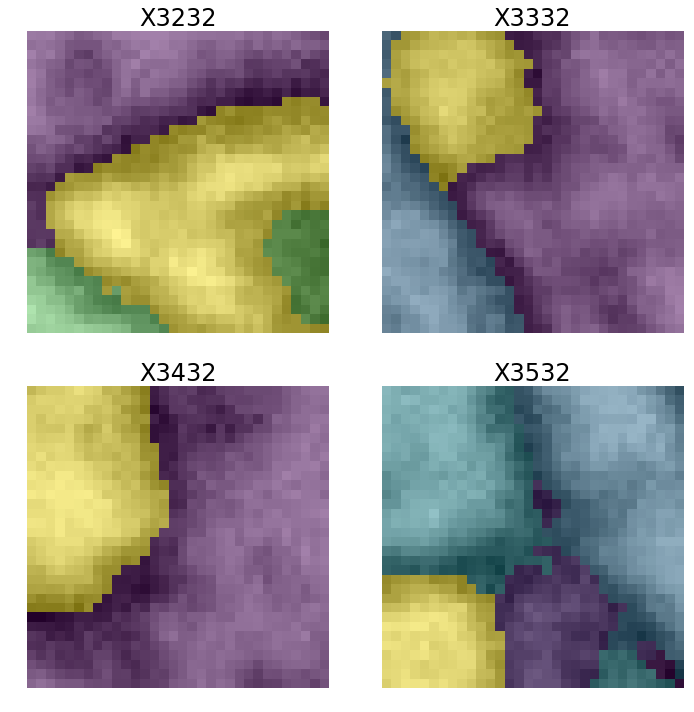

In [107]:
# Plotting several images from the array

plt.figure(figsize=(10, 10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(chunk_gry[:, :, i * 100], cmap='gray')
    plt.imshow(chunk_gt[:, :, i * 100], alpha=0.5)
    plt.axis('off')
    plt.title('X{}'.format(3232 + i * 100), fontsize=24)
    
plt.tight_layout()
plt.show()


# Where is synapse?

In [69]:
# Load the synapse.json file:

with open('/media/haein/DATA/FlyEM/synapse.json', 'r') as f:
    synapse = json.load(f)
    

## Exploring the structure of the synapse.json

In [108]:
# Get the location of specific 'T-bar': 

data = synapse['data'][22]
loc_tbar = data['T-bar']['location']
print("The voxel coordinates of T-bar is [x, y, z] = " + str(tbar))

# Get the locations of its 'partners':

partners = data['partners']
loc_part = [partners[i]['location'] for i in range(len(partners))]

for i, loc in enumerate(loc_part):
    print("The voxel coordinates of its partner {} is [x, y, z] = ".format(i) + str(loc_part[i]))


The voxel coordinates of T-bar is [x, y, z] = [1888, 3111, 7120]
The voxel coordinates of its partner 0 is [x, y, z] = [1884, 3090, 7118]
The voxel coordinates of its partner 1 is [x, y, z] = [1880, 3114, 7111]


## Create the DataFrame which contains of information about T-bars: Tbar

In [140]:
# Get all of the T-bar locations in synapse.json:

data = synapse['data']

tbar_loc_list = []

for i in range(len(data)):
    tbar = data[i]['T-bar']
    x, y, z = tbar['location']
    tbar_loc_list.append([i, tbar['body ID'], x, y, z])
    
print('The DataFrame of T-bar would have ' + str(len(tbar_loc_list)) + ' of rows')

# Create the DataFrame of T-bar:

col_name = ['data', 'body ID', 'T-bar loc (x)', 'T-bar loc (y)', 'T-bar loc (z)']

Tbar = pd.DataFrame(tbar_loc_list, columns=col_name)
Tbar.tail(5)
    

The DataFrame of T-bar would have 52871 of rows


,data,body ID,T-bar loc (x),T-bar loc (y),T-bar loc (z)
52866,52866,39326,5015,3301,1731
52867,52867,20789,5015,3653,1876
52868,52868,39727,5017,3134,1834
52869,52869,28700,5017,3468,2353
52870,52870,82080,5017,3695,1906


In [ ]:
# Get all of the T-bar locations in synapse.json:

data = synapse['data']

tbar_loc_list = []

for i in range(len(data)):
    partners = data[i]['partners']
    for j in range(len(partners)):
    x, y, z = tbar['location']
    tbar_loc_list.append([i, tbar['body ID'], x, y, z])
    
print('The DataFrame of T-bar would have ' + str(len(tbar_loc_list)) + ' of rows')

# Create the DataFrame of T-bar:

col_name = ['data', 'body ID', 'T-bar loc (x)', 'T-bar loc (y)', 'T-bar loc (z)']

Tbar = pd.DataFrame(tbar_loc_list, columns=col_name)
Tbar.tail(5)
    

## How to specify where T-bars and their partners in the roi-cubics ? 

In [82]:
roi.head(5)

,z_start,z_end,y_start,y_end,x0_start,x1_end
0,1696,1728,2464,2496,3232,4800
1,1696,1728,2496,2528,3232,4800
2,1696,1728,2528,2560,3232,4800
3,1696,1728,2560,2592,3232,4800
4,1696,1728,2592,2624,3232,4800


In [118]:
roi.where((roi['y_start'] <= 3090) & (roi['y_end'] >= 3090)).dropna()

,z_start,z_end,y_start,y_end,x0_start,x1_end
19,1696.0,1728.0,3072.0,3104.0,2720.0,4800.0
69,1728.0,1760.0,3072.0,3104.0,2720.0,4800.0
119,1760.0,1792.0,3072.0,3104.0,2720.0,4800.0
169,1792.0,1824.0,3072.0,3104.0,2720.0,4800.0
219,1824.0,1856.0,3072.0,3104.0,2720.0,4800.0
269,1856.0,1888.0,3072.0,3104.0,2720.0,4800.0
319,1888.0,1920.0,3072.0,3104.0,2720.0,4800.0
369,1920.0,1952.0,3072.0,3104.0,2720.0,4800.0
419,1952.0,1984.0,3072.0,3104.0,2720.0,4800.0
469,1984.0,2016.0,3072.0,3104.0,2720.0,4800.0
